# Logistic Regression

## Overview

A logistic regression can be used when the outcome we are interested in is a categorical one. In this case, we are interested in whether or not a patient was readmitted within 30 days -- an outcome with two categories (yes or no). 

## Running the Logistic Regression and Checking Results

There a few things to note as this process happens. First, we'll read in the preprocessed data that has categorical features converted to separate, binary columns. Next, we'll split the data into a training and a test set. The training data is used to build the logistic model; it is the data that the model "learns" on. Once the model is constructed from the training data, we'll run it on the test data to make sure it generalizes -- or works on other data sets -- well. The test data was set aside before building the model precisely for this purpose. 

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# read in data
readmit = pd.read_csv('diabetes_readmission_onehot.csv') 

In [3]:
# capture independent variables in list
features = list(readmit) 
features = [e for e in features if e not in ('Unnamed: 0', 'readmit30')]

In [4]:
# split the data into a training and test set
X = readmit[features].values
y = readmit.readmit30.values 
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = .2, 
                                                random_state = 7, stratify = y)

Now that the data set is split, we can set up the regression and run it. There are a few important things happening in this process. First is the creation of a grid of possible values for C, which is a tuning parameter used when data cannot be separated into two categories with a clean, straight line in the x-y plane. When a best attempt at such a line is drawn, some observations that belong to one category might still lie on the "wrong" side of the separating line. To account for this dynamic, we introduce a tuning parameter into the math of logistic regression. This step ideally creates a value of C that is neither too high nor too low. The former could create a model that is too biased toward the training data to be generalizable, and the latter could create a model with too much variance to have much predictive value (kind of like a jack of all trades being a master of none). 

The second tool at hand is the GridSearchCV function. The grid search allows us to perform an exhaustive search for the best C in just one line of code. The process also uses cross validation and an l2 penalty, which both help manage variance and in turn keep the model from becoming too general to the point that its predictive value is weakened.

In [5]:
# create grid, run grid search w/ logistic regression, find best C and its accuracy score

C_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]} #dictionary w/ C as key and possible values
weights = {0: .1, 1: .9} # class weights to address imbalance of dependent variable 
clf_grid = GridSearchCV(LogisticRegression(penalty='l2', class_weight = weights), C_grid, 
                        cv = 5, scoring = 'accuracy') 
clf_grid.fit(Xtrain, Ytrain) #fit model on training data

print(clf_grid.best_params_, clf_grid.best_score_) #output best C and best accuracy score

{'C': 0.001} 0.807966339411


In [6]:
# check model accuracy on training data 
clf_grid_best = LogisticRegression(C = clf_grid.best_params_['C'], penalty='l2', 
                                    class_weight = weights)
clf_grid_best.fit(Xtrain, Ytrain)

x_pred_train = clf_grid_best.predict(Xtrain) #capture predictions for Y based on data in X
accuracy_score(x_pred_train, Ytrain)

0.80852734922861147

In [7]:
# check model accuracy on test data 
clf_grid_best.fit(Xtest, Ytest)
x_pred_test = clf_grid_best.predict(Xtest)
accuracy_score(x_pred_test, Ytest)

0.82436981075622706

In addition to accuracy, it often helps to check another metric called precision-recall. Precision-recall analysis reports various percentages for how well a model does at classifying observations accurately for an outcome. I'll talk about this more once we produce the numbers in classification reports below. 

In [8]:
# classification report for training data 
report_train = classification_report(Ytrain, x_pred_train) #classify actual Y values in test data vs. those predicted in X
print(report_train)

             precision    recall  f1-score   support

          0       0.95      0.84      0.89     48616
          1       0.24      0.52      0.33      4859

avg / total       0.88      0.81      0.84     53475



In [9]:
# classification report for test data
report_test = classification_report(Ytest, x_pred_test) 
print(report_test)

             precision    recall  f1-score   support

          0       0.95      0.86      0.90     12154
          1       0.26      0.50      0.34      1215

avg / total       0.88      0.82      0.85     13369



Precision reflects the percentage of positive (i.e., readmitted within 30 days) predictions that are correct. If the model classifies 100 observations as positive, and 80 of those were in fact positive, then the model's precision is .8 (or 80%). 

Recall captures the percent of true positives that are classified as positive. Returning to our model's context, if there were 1,000 patients readmitted within thirty days and the model detected 850 of them, then the model's recall would be .85 (or 85%).

Finally, the F1-score (the harmonic mean) shows the weighted average of precision and recall. It is a useful metric because it factors in both false positives and false negatives. The model here has an F1-score of .85, which is pretty good considering that 1.00 would be a perfect score and .5 would be as good as random guessing. However, this higher score masks the model's weak performance with positive cases.

## Accuracy Score vs. ROC Curve

The chosen model (with the best C and accuracy score) has an accuracy score of about .824, which means that about 82.4% of the model's predictions made about readmission within 30 days were correct. While accuracy can be an okay starting point to assess model performance, it isn't necessarily the best one for this case. Accuracy score is usually better when the number of observations is equal for each category within a feature, so let's look at another performance metric -- the area under an ROC curve -- next. 

An ROC curve reflects how well a model differentiates positive (readmission within 30 days, in our case) and negative outcomes. A model making all predictions correctly has an area of 1. A model that performs no better than random guessing has an area of 0.5. As we'll see in a moment, the curve itself plots the true positive rate against the false positive rate to help observers gauge performance.

In [19]:
# logistic regression with area under ROC curve as metric 
C_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]} 
clf_grid_ROC = GridSearchCV(LogisticRegression(penalty='l2', class_weight = weights), 
                            C_grid, cv = 5, scoring = 'roc_auc')
clf_grid_ROC.fit(Xtrain, Ytrain) 
print(clf_grid_ROC.best_params_, clf_grid_ROC.best_score_) 

{'C': 0.01} 0.784683277694


In [11]:
# check ROC performance on training set
clf_grid_ROC_best = LogisticRegression(penalty='l2', class_weight = weights, 
                                       C = clf_grid_ROC.best_params_['C'])
clf_grid_ROC_best.fit(Xtrain, Ytrain)

probs_train = clf_grid_ROC_best.predict_proba(Xtrain)
preds_train = probs_train[:,1]
roc_auc_score(Ytrain, preds_train)

0.78994358026510514

In [12]:
# check ROC performance on test set 
clf_grid_ROC_best.fit(Xtest, Ytest)

probs_test = clf_grid_ROC_best.predict_proba(Xtest)
preds_test = probs_test[:,1]
roc_auc_score(Ytest, preds_test)

0.79437791145322278

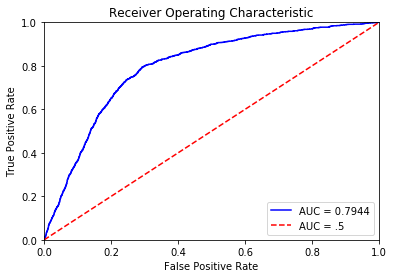

In [14]:
# plot ROC curve from test data
fpr, tpr, threshold = roc_curve(Ytest, preds_test) #find true- and false-positive rates for relevant decision thresholds
roc_auc = auc(fpr, tpr) #compute area under ROC curve using trapezoidal rule (not a binary classification here)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'blue', label = 'AUC = %0.4f' % roc_auc) #create line with AUC value for test data
plt.plot([0, 1], [0, 1],'r--', label = 'AUC = .5') #create line with AUC=.5 for comparison
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

A (theoretically) perfect ROC curve comprises a vertical line along the y-axis joined with a horizontal line at y = 1 (essentially an upside-down *L*. The closer our curve is to that ideal one, the better it is. So our model is looking pretty good at this point. Another line of comparison is the dotted red line, which represents at 50% success rate for binary predictions. If our model's line falls to this point, it is no better than randomly guessing would be. 

## Confusion Matrix

A third way to evaluate model performance is a confusion matrix, which puts our model's predictions into four categories:

- In the top-left quadrant is the number of observations classified as not readmitted within 30 days that were in fact not readmitted within 30 days. This is the true negative count. 
- In the top-right quadrant is the number of observations classified as readmitted within 30 days that were in fact not readmitted within 30 days. This is the false positive count. 
- In the lower left quadrant is the number of observations classified as not readmitted within 30 days that were in fact readmitted within 30 days. This is the false negative count. 
- In the lower right quadrant is the number of observations classified as readmitted within 30 days that were in fact readmitted within 30 days. This is the true positive count. 

In [10]:
# confusion matrix for training data
actual_train = pd.Series(Ytrain, name = 'Actual')
predict_train = pd.Series(x_pred_train, name = 'Predicted') 
train_ct = pd.crosstab(actual_train, predict_train, margins = True) 
print(train_ct)

Predicted      0      1    All
Actual                        
0          40694   7922  48616
1           2317   2542   4859
All        43011  10464  53475


In [11]:
 # as percentages
TN_train = train_ct.iloc[0,0] / train_ct.iloc[0,2]
TP_train = train_ct.iloc[1,1] / train_ct.iloc[1,2]
print('Training accuracy for not readmitted: {}'.format('%0.3f' % TN_train))
print('Training accuracy for readmitted (Recall): {}'.format('%0.3f' % TP_train))

Training accuracy for not readmitted: 0.837
Training accuracy for readmitted (Recall): 0.523


In [22]:
# confusion matrix for test data
actual_test = pd.Series(Ytest, name = 'Actual')
predict_test = pd.Series(x_pred_test, name = 'Predicted') 
test_ct = pd.crosstab(actual_test, predict_test, margins = True) 
print(test_ct)

Predicted      0     1    All
Actual                       
0          10408  1746  12154
1            602   613   1215
All        11010  2359  13369


In [23]:
 # as percentages
TN_test = test_ct.iloc[0,0] / test_ct.iloc[0,2]
TP_test = test_ct.iloc[1,1] / test_ct.iloc[1,2]
print('Test accuracy for not readmitted: {}'.format('%0.3f' % TN_test))
print('Test accuracy for readmitted (Recall): {}'.format('%0.3f' % TP_test))

Test accuracy for not readmitted: 0.856
Test accuracy for readmitted (Recall): 0.505


The model does quite well predicting negative (labeled False in the matrices) cases, in which patients were not readmitted within thirty days. Percent accuracy is in the mid-80s. For positive cases, however, the model is just above 50% accuracy, which is just a little better than random chance. (You may also notice some overlap in the numbers here and those from the precision-recall part earlier.) 

## Improvement Through Undersampling

Although the accuracy for non-readmitted patients was quite good, the accuracy for positive cases (recall) was just slightly better than a random guess would be. Part of the reason for this issue might be the significant imblance in positive and negative outcomes. As we saw earlier, there are about 11 patients who were not readmitted within 30 days for every patient who was. In order to see if our model's performance is due to this imbalance, we can try the undersampling process with observations that did not show readmission within 30 days. Here, we'll use random undersampling to randomly choose fewer observations with the negative outcome in order to create a balance with positive outcomes. 

In [12]:
# capture independent variables in list
features = list(readmit) 
features = [e for e in features if e not in ('Unnamed: 0', 'readmit30')]

In [47]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler 

X = readmit[features].values #majority class to be undersampled
Y = readmit.readmit30.values 

rus = RandomUnderSampler(random_state = 31)
X_res, Y_res = rus.fit_sample(X, Y)
Counter(Y_res) 

Counter({0: 6074, 1: 6074})

In [45]:
# train, test, split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_res, Y_res, test_size = .2, 
                                                random_state = 31, stratify = Y_res)

In [46]:
# create grid, run grid search w/ logistic regression, find best C and its accuracy score
C_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]} 
clf_grid = GridSearchCV(LogisticRegression(penalty='l2'), C_grid, cv = 5, scoring = 'accuracy') 
clf_grid.fit(Xtrain, Ytrain) 

print(clf_grid.best_params_, clf_grid.best_score_) 

{'C': 0.01} 0.718769294093


In [29]:
# check model accuracy on training data 
clf_grid_best = LogisticRegression(C = clf_grid.best_params_['C'], penalty='l2')
clf_grid_best.fit(Xtrain, Ytrain)

x_pred_train = clf_grid_best.predict(Xtrain) #capture predictions for Y based on data in X
accuracy_score(x_pred_train, Ytrain)

0.72844206626877961

In [30]:
# check model accuracy on test data 
clf_grid_best.fit(Xtest, Ytest)

x_pred_test = clf_grid_best.predict(Xtest)
accuracy_score(x_pred_test, Ytest)

0.66255144032921809

In [31]:
# confusion matrix for logistic model w/ random undersampling
actual = pd.Series(Ytest, name = 'Actual')
predicted_rus = pd.Series(clf_grid_best.predict(Xtest), name = 'Predicted')
ct_rus = pd.crosstab(actual, predicted_rus, margins = True)
print(ct_rus)

Predicted     0     1   All
Actual                     
0           846   369  1215
1           451   764  1215
All        1297  1133  2430


In [32]:
# confusion matrix with percentages
TN_rus = ct_rus.iloc[0,0] / ct_rus.iloc[0,2]
TP_rus = ct_rus.iloc[1,1] / ct_rus.iloc[1,2]
print('Logistic Regression accuracy for not readmitted: {}'.format('%0.3f' % TN_rus))
print('Logistic Regression accuracy for readmitted (Recall): {}'.format('%0.3f' % TP_rus))

Logistic Regression accuracy for not readmitted: 0.696
Logistic Regression accuracy for readmitted (Recall): 0.629


The undersampling approach improves the model's recall noticeably, although accuracy for negative cases suffered. We can try another technique called oversampling to see if further improvements are possible.

## Oversampling (SMOTE)

In addition to undersampling the majority class (not readmitted within 30 days), we can also try oversampling the minority class (readmitted within 30 days). Here, we'll use a common oversampling method called SMOTE (Synthetic Minority Oversampling Technique). 

In [33]:
from imblearn.over_sampling import SMOTE 

X = readmit[features].values 
Y = readmit.readmit30.values #minority class to be oversampled

sm = SMOTE(random_state = 31)
X_resamp, Y_resamp = sm.fit_sample(X, Y)
Counter(Y_resamp) 

Counter({0: 60770, 1: 60770})

In [34]:
# train, test, split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_resamp, Y_resamp, test_size = .2, 
                                                random_state = 31, stratify = Y_resamp)

In [35]:
# create grid, run grid search w/ logistic regression, find best C and its accuracy score
C_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]} 
clf_grid = GridSearchCV(LogisticRegression(penalty='l2'), C_grid, cv = 5, scoring = 'accuracy') 
clf_grid.fit(Xtrain, Ytrain) 

print(clf_grid.best_params_, clf_grid.best_score_) 

{'C': 0.01} 0.724555701827


In [36]:
# check model accuracy on training data 
clf_grid_best = LogisticRegression(C = clf_grid.best_params_['C'], penalty='l2')
clf_grid_best.fit(Xtrain, Ytrain)

x_pred_train = clf_grid_best.predict(Xtrain) #capture predictions for Y based on data in X
accuracy_score(x_pred_train, Ytrain)

0.72503908178377485

In [37]:
# check model accuracy on test data 
clf_grid_best.fit(Xtest, Ytest)

x_pred_test = clf_grid_best.predict(Xtest)
accuracy_score(x_pred_test, Ytest)

0.72766167516866875

In [38]:
# confusion matrix with SMOTE oversampling
actual = pd.Series(Ytest, name = 'Actual')
predicted_sm = pd.Series(clf_grid_best.predict(Xtest), name = 'Predicted')
ct_sm = pd.crosstab(actual, predicted_sm, margins = True)
print(ct_sm)

Predicted      0      1    All
Actual                        
0           9487   2667  12154
1           3953   8201  12154
All        13440  10868  24308


In [39]:
# confusion matrix with percentages
TN_sm = ct_sm.iloc[0,0] / ct_sm.iloc[0,2]
TP_sm = ct_sm.iloc[1,1] / ct_sm.iloc[1,2]
print('Accuracy for not readmitted: {}'.format('%0.3f' % TN_sm))
print('Accuracy for readmitted (Recall): {}'.format('%0.3f' % TP_sm))

Accuracy for not readmitted: 0.781
Accuracy for readmitted (Recall): 0.675


The oversampling approach improved accuracy for both positive and negative cases when compared with undersampling. The global accuracy (about 73%) is a little lower than it was in the original model (about 80%), but the trade-off to improve recall is likely worth it. Predictive value with respect to the positive class is more valuable, so the oversampling model is our best choice with logistic regression.

The ten features with the highest predictive values with respect to readmission are reproduced below. (In the interest of brevity, I did not reproduce full models.) 

A higher coefficient in logistic regression indicates a higher effect on the odds of readmission within 30 days. For example, mathematically, num_visits (number of hospital visits) has a coefficient of 0.589. This means that, controlling for other model variables, the estimated odds of readmission are e^0.589 = 1.802 times higher for each additional visit that a patient makes. 

In [25]:
# feature evaluation for logistic regression
logistic_coefs = clf_grid_best.coef_[0]
logistic_coef_df = pd.DataFrame({'feature': features, 'coefficient': logistic_coefs})
logistic_df = logistic_coef_df.sort_values('coefficient', ascending = False)
logistic_df.head(10)

,coefficient,feature
7,0.589403,num_visits
5,0.284375,number_inpatient
31,0.180511,discharge_disposition_id_3
44,0.138675,discharge_disposition_id_22
121,0.082984,first_diag_injury
33,0.076460,discharge_disposition_id_5
20,0.072813,age_[70-80)
150,0.069777,num_lab_procs_[61-70]
19,0.064836,age_[60-70)
89,0.059289,glipizide_Steady


## Looping Processes to Correct Imbalanced Data

Now that successful corrections for the imbalanced dependent variable have been made, we can check repeat those processes a few times to ensure that we didn't "just get lucky" with the one-off uses of random undersampling and SMOTE. 

In [3]:
# capture independent variables in list
features = list(readmit) 
features = [e for e in features if e not in ('Unnamed: 0', 'readmit30')]

In [4]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

X = readmit[features].values #majority class to be undersampled
Y = readmit.readmit30.values 

In [5]:
# multiple calls of RandomUnderSampler

n_trials = 10 # number of trials

# Declare empty lists for true-positive and true-negative rates
TNR = []
TPR = [] 

# for loop such that variable "trial" varies from 0 to n_trials-1 
 # which means the loop executes n_trials times
for trial in range(n_trials):
    
    # assume that X and Y are already defined, use RandomUnderSampler
    rus = RandomUnderSampler(random_state = 31*trial) # randomized seed
    X_res, Y_res = rus.fit_sample(X, Y)
    print(Counter(Y_res)) #print results for Counter for each sample (trial)
    
    # train/test split
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_res, Y_res, test_size = .2, 
                                                    stratify = Y_res, random_state = 2*trial)
    
    # fit hyper-parameter
    # create grid, run grid search w/ logistic regression, find best C and its accuracy score
    C_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]} 
    clf_grid = GridSearchCV(LogisticRegression(penalty='l2'), C_grid, cv = 5, scoring = 'accuracy') 
    clf_grid.fit(Xtrain, Ytrain) 
    print(clf_grid.best_params_, clf_grid.best_score_) 
    
    # use that parameter with Logistic regression
    # check model accuracy on training data 
    clf_grid_best = LogisticRegression(C = clf_grid.best_params_['C'], penalty='l2')
    clf_grid_best.fit(Xtrain, Ytrain)
    x_pred_train = clf_grid_best.predict(Xtrain) #capture predictions for Y based on data in X
    accuracy_score(x_pred_train, Ytrain)
    
    # check model accuracy on test data 
    clf_grid_best.fit(Xtest, Ytest)
    x_pred_test = clf_grid_best.predict(Xtest)
    accuracy_score(x_pred_test, Ytest)
    
    # confusion matrix for logistic model w/ random undersampling
    actual = pd.Series(Ytest, name = 'Actual')
    predicted_rus = pd.Series(clf_grid_best.predict(Xtest), name = 'Predicted')
    ct_rus = pd.crosstab(actual, predicted_rus, margins = True)
    print(ct_rus)
    
    # capture given trial's true negative rate, add to array
    tnr = ct_rus.iloc[0,0] / ct_rus.iloc[0,2]
    TNR.append(tnr)
    
    # same process for true positive rate
    tpr = ct_rus.iloc[1,1] / ct_rus.iloc[1,2]
    TPR.append(tpr)
    
    # print TNR, TPR, and trial no.
    print('Logistic Regression accuracy for not readmitted: {}'.format('%0.3f' % tnr))
    print('Logistic Regression accuracy for readmitted (Recall): {}'.format('%0.3f' % tpr))
    print('Logistic Regression trial count: {}'.format(trial + 1))
    print() 

Counter({1: 6074, 0: 6074})
{'C': 0.001} 0.713727104342
Predicted     0     1   All
Actual                     
0           885   330  1215
1           408   807  1215
All        1293  1137  2430
Logistic Regression accuracy for not readmitted: 0.728
Logistic Regression accuracy for readmitted (Recall): 0.664
Logistic Regression trial count: 1

Counter({1: 6074, 0: 6074})
{'C': 0.01} 0.713212595184
Predicted     0     1   All
Actual                     
0           972   243  1215
1           435   780  1215
All        1407  1023  2430
Logistic Regression accuracy for not readmitted: 0.800
Logistic Regression accuracy for readmitted (Recall): 0.642
Logistic Regression trial count: 2

Counter({1: 6074, 0: 6074})
{'C': 0.01} 0.714653220827
Predicted     0     1   All
Actual                     
0           977   238  1215
1           406   809  1215
All        1383  1047  2430
Logistic Regression accuracy for not readmitted: 0.804
Logistic Regression accuracy for readmitted (Recall): 0.6

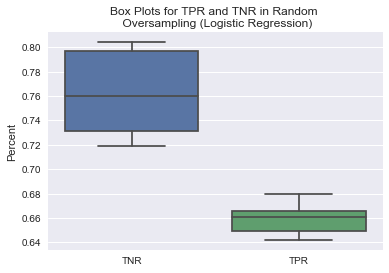

In [23]:
# plot TNR and TPR as box plots
plots = pd.DataFrame({'TPR': TPR, 'TNR': TNR})

sns.boxplot(data = plots)  
plt.title('Box Plots for TPR and TNR in Random \n Oversampling (Logistic Regression)')
plt.ylabel('Percent')
plt.show()

In [13]:
# multiple calls of SMOTE
from imblearn.over_sampling import SMOTE 

n_trials = 10 # number of trials

# Declare empty lists for true-positive and true-negative rates
TNR_smote = []
TPR_smote = [] 

# for loop such that variable "trial" varies from 0 to n_trials-1 
 # which means the loop executes n_trials times
for trial in range(n_trials):
    
    # assume that X and Y are already defined, use RandomUnderSampler
    sm = SMOTE(random_state = 31*trial) #randomize seed
    X_resamp, Y_resamp = sm.fit_sample(X, Y)
    print(Counter(Y_resamp)) #print results for Counter for each sample (trial)
        
    # train/test split
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_res, Y_res, test_size = .2, 
                                                    stratify = Y_res)
    
    # fit hyper-parameter
    # create grid, run grid search w/ logistic regression, find best C and its accuracy score
    C_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]} 
    clf_grid = GridSearchCV(LogisticRegression(penalty='l2'), C_grid, cv = 5, 
                            scoring = 'accuracy') 
    clf_grid.fit(Xtrain, Ytrain) 
    print(clf_grid.best_params_, clf_grid.best_score_) 
    
    # use that parameter with Logistic regression
    # check model accuracy on training data 
    clf_grid_best = LogisticRegression(C = clf_grid.best_params_['C'], penalty='l2')
    clf_grid_best.fit(Xtrain, Ytrain)
    x_pred_train = clf_grid_best.predict(Xtrain) #capture predictions for Y based on data in X
    accuracy_score(x_pred_train, Ytrain)
    
    # check model accuracy on test data 
    clf_grid_best.fit(Xtest, Ytest)
    x_pred_test = clf_grid_best.predict(Xtest)
    accuracy_score(x_pred_test, Ytest)
    
    # confusion matrix for logistic model w/ SMOTE
    actual = pd.Series(Ytest, name = 'Actual')
    predicted_sm = pd.Series(clf_grid_best.predict(Xtest), name = 'Predicted')
    ct_sm = pd.crosstab(actual, predicted_sm, margins = True)
    print(ct_sm)

    # capture given trial's true negative rate, add to array
    tnr_smote = ct_sm.iloc[0,0] / ct_sm.iloc[0,2]
    TNR_smote.append(tnr_smote)
    
    # same process for true positive rate
    tpr_smote = ct_sm.iloc[1,1] / ct_sm.iloc[1,2]
    TPR_smote.append(tpr_smote)
    
    # print TNR, TPR, and trial no.
    print('Logistic Regression accuracy for not readmitted: {}'.format('%0.3f' % tnr_smote))
    print('Logistic Regression accuracy for readmitted (Recall): {}'.format('%0.3f' % tpr_smote))
    print('Logistic Regression trial count: {}'.format(trial + 1))
    print() 

Counter({1: 60770, 0: 60770})
{'C': 0.01} 0.718151883104
Predicted     0     1   All
Actual                     
0           982   233  1215
1           422   793  1215
All        1404  1026  2430
Logistic Regression accuracy for not readmitted: 0.808
Logistic Regression accuracy for readmitted (Recall): 0.653
Logistic Regression trial count: 1

Counter({1: 60770, 0: 60770})
{'C': 0.001} 0.713727104342
Predicted     0     1   All
Actual                     
0           930   285  1215
1           381   834  1215
All        1311  1119  2430
Logistic Regression accuracy for not readmitted: 0.765
Logistic Regression accuracy for readmitted (Recall): 0.686
Logistic Regression trial count: 2

Counter({1: 60770, 0: 60770})
{'C': 0.001} 0.721238938053
Predicted     0     1   All
Actual                     
0           905   310  1215
1           377   838  1215
All        1282  1148  2430
Logistic Regression accuracy for not readmitted: 0.745
Logistic Regression accuracy for readmitted (Recal

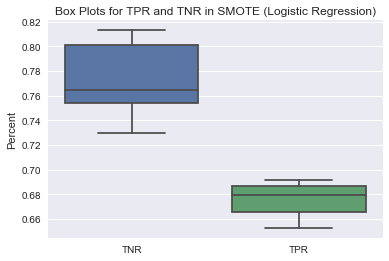

In [24]:
# plot SMOTE TNR and TPR as box plots
plots_smote = pd.DataFrame({'TPR': TPR_smote, 'TNR': TNR_smote})

sns.boxplot(data = plots_smote) 
plt.title('Box Plots for TPR and TNR in SMOTE (Logistic Regression)')
plt.ylabel('Percent')
plt.show()